### Plan
1. Get Image
2. Correct Distorsion AND top view
3. Grid
4. Detect
5. A* Path search

***

1. Get Image

1.1 Using a precaptured image for prototyping

In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 
from skimage import feature, measure

def get_image_from_camera(image_path: str):
    pass
    
# placeholder function
def get_image(image_path: str)-> np.ndarray:
    """
    Input: filepath of a PNG image
    Output: image as numpy array
    Example: get_image(os.path.join("..", "robot-env", "s1.png"))
    """
    try:
        img = cv2.imread(image_path) # BGR
        return img
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

img_name = "r2.jpg"
img = get_image(os.path.join("..", "robot-env", img_name))
print(img.shape, type(img[0][0][0]))

(1600, 1200, 3) <class 'numpy.uint8'>


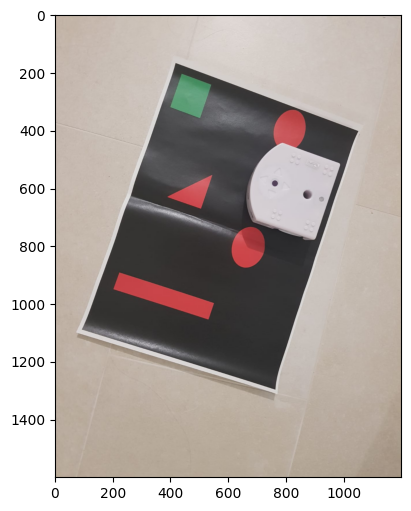

In [7]:
def show_cv2_img(img: np.ndarray, fig_size=(12,12), color="RGB", _axis=True, _title=None, _cmap=None):
    plt.figure(figsize=fig_size)
    if color == "BGR":
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=_cmap) # BGR -> RGB
    else:
        plt.imshow(img, cmap=_cmap)
        
    if _title is not None:
        plt.title(_title)
    if not _axis:
        plt.axis('off')
    
    plt.show()

show_cv2_img(img, (6,6), "BGR")

1.2 Using the provided camera
Capture an image and destroy window when finished.

In [4]:
import cv2

cam = cv2.VideoCapture(1, cv2.CAP_DSHOW) #Specify DirectShow for faster connection
if not cam.isOpened(): 
    print("Camera could not be opened") 
    cam.release()
    exit()

ret, frame = cam.read()
if not ret:
    print("Frame could not be read for some reason")
    cam.release()
    exit()
cv2.imshow('An image', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
cam.release()

2.1 Correct Distorsion
- Using OpenCV and the OpenCV chessboard
- https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
- The 9*6 pattern https://github.com/opencv/opencv/blob/4.x/doc/pattern.png

In [5]:
#Generate 20 images
import cv2
import os

cam = cv2.VideoCapture(1, cv2.CAP_DSHOW) #Specify DirectShow for faster connection
if not cam.isOpened(): 
    print("Camera could not be opened") 
    cam.release()
    exit()

#Create folder for the Calibration Images
folder_name = "Chessboard_Calib_imgs"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

img_count=0
while img_count<20:
    ret, frame = cam.read()
    if not ret:
        print("Frame could not be read for some reason")
        cam.release()
        exit()

    cv2.imshow(f"Take image {img_count+1} by pressing s",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        filepath = os.path.join(folder_name, f"Calib_img{img_count}.png")
        cv2.imwrite(filepath,frame)
        img_count+=1
        cv2.destroyAllWindows()
    

cv2.destroyAllWindows()
cam.release()

KeyboardInterrupt: 

In [ ]:
#Get calibration matrix
import numpy as np
import cv2 as cv
import glob

#square size to be measured
square_size=24 #mm
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objp=objp*square_size
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob(r'Chessboard_Calib_imgs\*.png')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (9,6), corners2, ret)
        cv.imshow(img, img)
        cv.waitKey(250)

cv.destroyAllWindows()

#Get calibration matrix
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Adapt calibration matrix to remove corners (will be cropted out anyways)
img = cv.imread('Chessboard_Calib_imgs\Calib_img0.png') 
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))

In [ ]:
#Undistord an image
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imshow('Undistored Image', dst)

2.2 Correct perspective

- https://theailearner.com/tag/cv2-warpperspective/
- https://stackoverflow.com/questions/22656698/perspective-correction-in-opencv-using-python
- https://discorpy.readthedocs.io/en/latest/tutorials/methods.html
- https://pyimagesearch.com/2021/10/06/opencv-contour-approximation/
- https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
- https://www.geeksforgeeks.org/convex-hull-algorithm/
- https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html
- https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

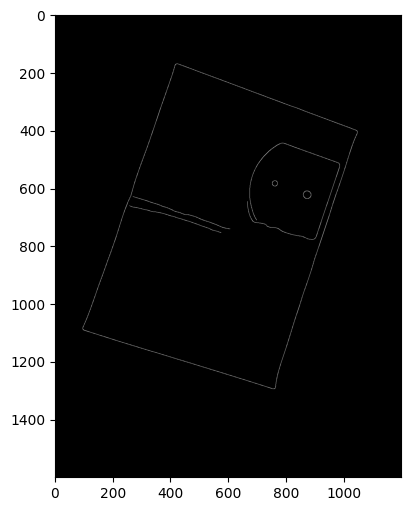

In [8]:
edges = feature.canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), sigma=5)
show_cv2_img(edges, (6,6), _cmap="gray")

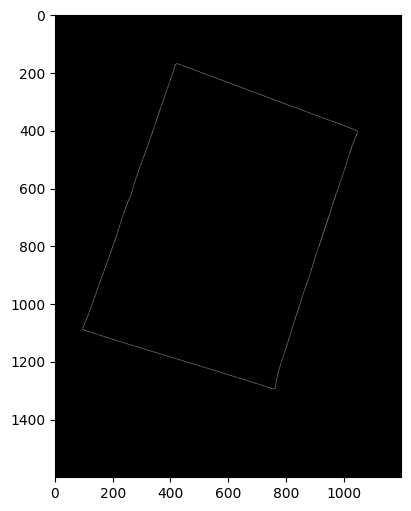

In [9]:
# largest connected component
def lcc(edges: np.ndarray)->np.ndarray:
    labels = measure.label(edges)
    counts = np.bincount(labels.ravel())
    counts[0] = 0 # disregard background
    largest_label = counts.argmax()
    mask = labels == largest_label
    return mask

lcc_mask = lcc(edges)
outer_edge = np.zeros_like(edges) # for visualization, no need for production
outer_edge[lcc_mask] = 1

show_cv2_img(outer_edge, (6,6), _cmap="gray")

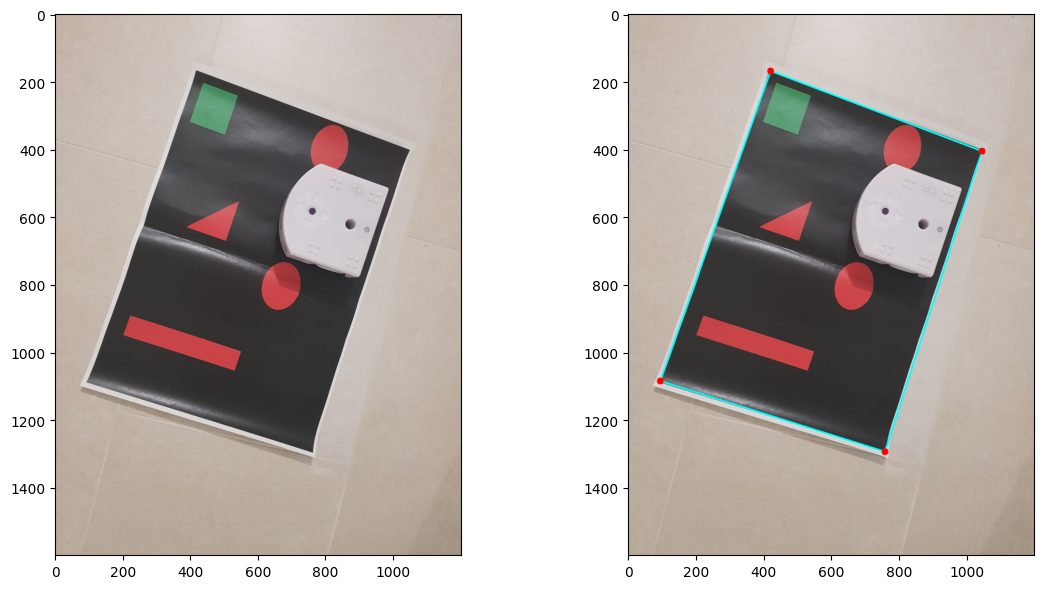

In [10]:
def find_corners(lcc_mask: np.ndarray, epsilon = 0.01)->np.ndarray: 
    contours, hierarchy = cv2.findContours((lcc_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    approx = cv2.approxPolyDP(largest_contour, epsilon * cv2.arcLength(largest_contour, True), True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2)
    else:
        while len(approx) != 4:
            epsilon = epsilon + 0.001
            approx = cv2.approxPolyDP(largest_contour, epsilon * cv2.arcLength(largest_contour, True), True)
        corners = approx.reshape(-1, 2)

    return corners, approx

corners, approx = find_corners(lcc_mask)

# visualization
img_corners = img.copy()
cv2.drawContours(img_corners, [approx], -1, (255, 255, 0), 3)
for corner in corners:
    cv2.circle(img_corners, tuple(corner), 10, (0, 0, 255), -1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

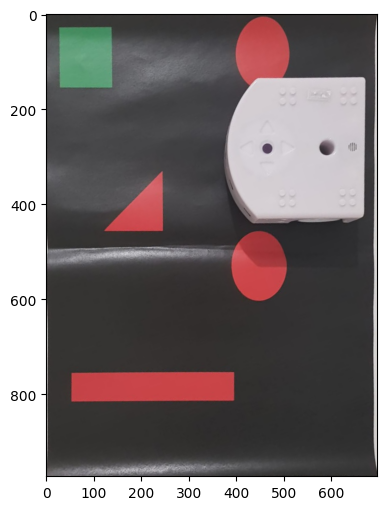

In [11]:
def order_points(corners):
    rect = np.zeros((4, 2), dtype="float32")
    
    _sum = corners.sum(axis=1)
    diff = np.diff(corners, axis=1)

    rect[0] = corners[np.argmin(_sum)]
    rect[2] = corners[np.argmax(_sum)]
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]
    
    return rect


ordered_corners = order_points(corners)

def compute_destination_size(ordered_corners):
    (top_left, top_right, bottom_right, bottom_left) = ordered_corners
    
    width_top = np.linalg.norm(top_right - top_left)
    width_bottom = np.linalg.norm(bottom_right - bottom_left)
    max_width = max(int(width_top), int(width_bottom))

    height_left = np.linalg.norm(top_left - bottom_left)
    height_right = np.linalg.norm(top_right - bottom_right)
    max_height = max(int(height_left), int(height_right))

    return max_width, max_height

max_width, max_height = compute_destination_size(ordered_corners)
destination_corners = np.array([
    [0, 0],
    [max_width - 1, 0],
    [max_width - 1, max_height - 1],
    [0, max_height - 1]], dtype="float32")

M = cv2.getPerspectiveTransform(ordered_corners, destination_corners)
warped = cv2.warpPerspective(img, M, (max_width, max_height), flags=cv2.INTER_LINEAR)
show_cv2_img(warped, (6,6), "BGR")

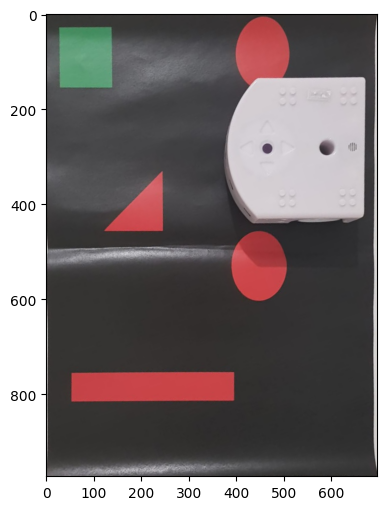

In [12]:
# compact version for production
def correct_distorsion(img: np.ndarray) -> np.ndarray:
    edges = feature.canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), sigma=5)
    lcc_mask = lcc(edges)
    corners, _ = find_corners(lcc_mask)
    return corners

def crop_image(img: np.ndarray, corners: np.ndarray) -> np.ndarray:
    ordered_corners = order_points(corners)
    max_width, max_height = compute_destination_size(ordered_corners)
    destination_corners = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered_corners, destination_corners)
    warped = cv2.warpPerspective(img, M, (max_width, max_height), flags=cv2.INTER_LINEAR)
    return warped

corners = correct_distorsion(img)
img = crop_image(img, corners)
show_cv2_img(img, (6,6), "BGR")

Observations
- we need to clearly see the outer edge (avoid r1 situation)
- we need to clearly see all the borders, thymio must not shadow an object
- folded A3 paper is a pain, adds white noise

3. Grid

blue_channel = img[:, :, 0]
green_channel = img[:, :, 1]
red_channel = img[:, :, 2]

x = 75

blue_intensity = blue_channel[x, :]
green_intensity = green_channel[x, :]
red_intensity = red_channel[x, :]

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(blue_intensity, color='blue')
plt.title(f'Blue Channel Intensity at x = {x}')
plt.xlabel('Y-axis')
plt.ylabel('Intensity')
plt.subplot(3, 1, 2)
plt.plot(green_intensity, color='green')
plt.title(f'Green Channel Intensity at x = {x}')
plt.xlabel('Y-axis')
plt.ylabel('Intensity')
plt.subplot(3, 1, 3)
plt.plot(red_intensity, color='red')
plt.title(f'Red Channel Intensity at x = {x}')
plt.xlabel('Y-axis')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

T_W = 196
thresholded_img = np.zeros_like(img)
white_mask = (img[:, :, 0] > T_W) & (img[:, :, 1] > T_W) & (img[:, :, 2] > T_W)
thresholded_img[white_mask] = [255, 255, 255]
show_cv2_img(thresholded_img, (6,6), "RGB")

T_RH = 140
T_RL = 120
thresholded_img = np.zeros_like(img)
red_mask = (img[:, :, 0] < T_RL) & (img[:, :, 1] < T_RL) & (img[:, :, 2] > T_RH)
thresholded_img[red_mask] = [255, 0, 0]
show_cv2_img(thresholded_img, (6,6), "RGB")

T_GH = 138
T_GL = 140
thresholded_img = np.zeros_like(img)
green_mask = (img[:, :, 0] < T_GL) & (img[:, :, 1] > T_GH) & (img[:, :, 2] < T_GL)
thresholded_img[green_mask] = [0, 255, 0]
show_cv2_img(thresholded_img, (6,6), "RGB")

Observation
- need a good lighting of the scene
- red is fine, this green was not 00ff00, maybe another color could work better for the goal. We could also reuse a color (red or white) and do shape identification (adds some complexity)

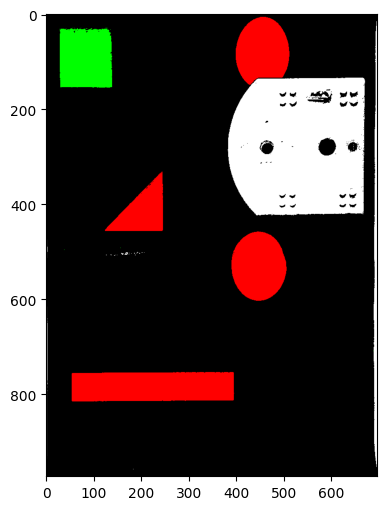

In [13]:
def threshold_image(img: np.ndarray, T_W: int, T_RH: int, T_RL: int, T_GH: int, T_GL: int) -> np.ndarray:
    thresholded_img = np.zeros_like(img)
    
    white_mask = (img[:, :, 0] > T_W) & (img[:, :, 1] > T_W) & (img[:, :, 2] > T_W)
    thresholded_img[white_mask] = [255, 255, 255]
    
    red_mask = (img[:, :, 0] < T_RL) & (img[:, :, 1] < T_RL) & (img[:, :, 2] > T_RH)
    thresholded_img[red_mask] = [0, 0, 255]
    
    green_mask = (img[:, :, 0] < T_GL) & (img[:, :, 1] > T_GH) & (img[:, :, 2] < T_GL)
    thresholded_img[green_mask] = [0, 255, 0]

    return thresholded_img

T_W = 196
T_RH = 140 
T_RL = 120
T_GH = 138
T_GL = 140

img = threshold_image(img, T_W = T_W, T_RH = T_RH, T_RL = T_RL, T_GH = T_GH, T_GL = T_GL)
show_cv2_img(img, (6,6), "BGR")

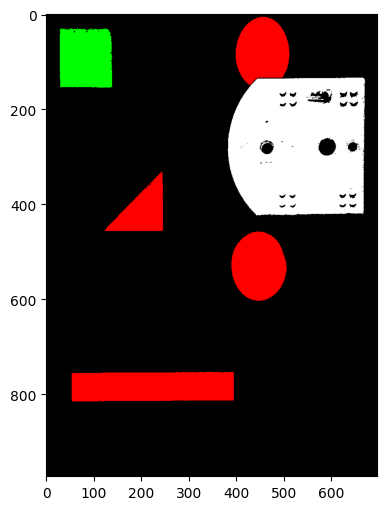

In [14]:
def filter_start_goal_noise(thresholed_image: np.ndarray)->np.ndarray:
    white_mask = np.all(thresholed_image == [255, 255, 255], axis=-1)
    red_mask = np.all(thresholed_image == [0, 0, 255], axis=-1)
    green_mask = np.all(thresholed_image == [0, 255, 0], axis=-1)

    def filter_largest_component(mask: np.ndarray)->np.ndarray:
        mask_uint8 = mask.astype(np.uint8) * 255
        num_labels, labels_im = cv2.connectedComponents(mask_uint8)
    
        if num_labels <= 1:
            return mask
    
        component_sizes = np.bincount(labels_im.flatten())
        component_sizes[0] = 0
        largest_label = component_sizes.argmax()
        largest_component_mask = labels_im == largest_label
    
        return largest_component_mask
    
    largest_white_mask = filter_largest_component(white_mask)
    largest_green_mask = filter_largest_component(green_mask)

    t_img = np.zeros_like(thresholed_image)
    t_img[largest_white_mask] = [255, 255, 255]
    t_img[largest_green_mask] = [0, 255, 0] 
    t_img[red_mask] = [0, 0, 255]

    return t_img

img = filter_start_goal_noise(img)
show_cv2_img(img, (6,6), "BGR")

white_component_img = np.zeros_like(img)
white_component_img[largest_white_mask] = [255, 255, 255]
show_cv2_img(white_component_img, (6,6), 'BGR')

green_component_img = np.zeros_like(img)
green_component_img[largest_green_mask] = [0, 255, 0]
show_cv2_img(green_component_img, (6,6), 'BGR')

red_component_img = np.zeros_like(img)
red_component_img[largest_red_mask] = [0, 0, 255]
show_cv2_img(red_component_img, (6,6), 'BGR')

Observations:
- could also filter red components for minimal size

Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle


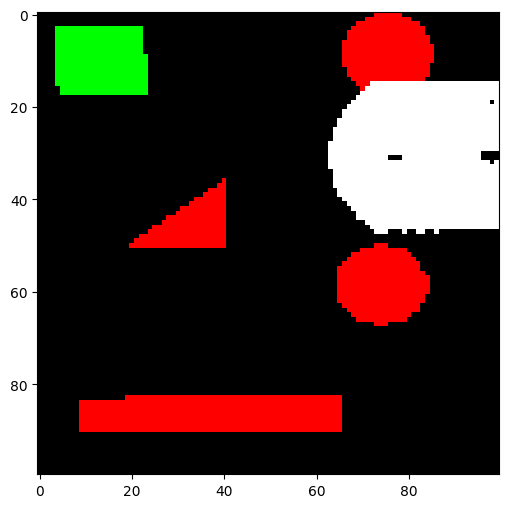

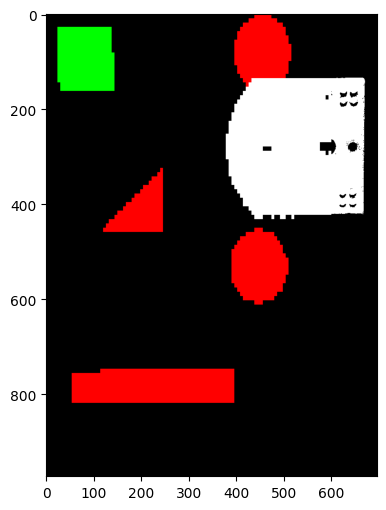

In [15]:
def get_dominant_color(block:np.ndarray)->np.ndarray:
    pixels = block.reshape(-1, 3)

    has_white = np.any(np.all(pixels == [255, 255, 255], axis=1))
    has_green = np.any(np.all(pixels == [0, 255, 0], axis=1))
    has_red = np.any(np.all(pixels == [0, 0, 255], axis=1))

    if has_white:
        if has_red:
            print("Collision start with obstacle")
        elif has_green:
            print("Collision start goal")
        return np.array([255, 255, 255], dtype=np.uint8)
    elif has_green:
        if has_red:
            print("Collision goal with obstacle")
        return np.array([0, 255, 0], dtype=np.uint8)    
    elif has_red:
        return np.array([0, 0, 255], dtype=np.uint8)
    else:
        return np.array([0, 0, 0], dtype=np.uint8) 


def discretize_image(img:np.ndarray, grid_size: int):
    """
    Discretizes an OpenCV image using a grid of grid_size x grid_size cells.
    """
    height, width, _ = img.shape
    cell_height = height // grid_size
    cell_width = width // grid_size

    grid_image = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    discretized_image = np.copy(img)

    for i in range(grid_size):
        for j in range(grid_size):
            start_y = i * cell_height
            end_y = (i + 1) * cell_height
            start_x = j * cell_width
            end_x = (j + 1) * cell_width

            block = img[start_y:end_y, start_x:end_x]

            dominant_color = get_dominant_color(block)

            grid_image[i, j] = dominant_color

            discretized_image[start_y:end_y, start_x:end_x] = dominant_color

    return grid_image, discretized_image


grid_size = 100
grid_image, discretized_img = discretize_image(img, grid_size)
show_cv2_img(grid_image, (6,6), "BGR")
show_cv2_img(discretized_img, (6,6), "BGR")

In [16]:
def image_to_grid(grid_image: np.ndarray) -> np.ndarray:
    grid = np.zeros((grid_image.shape[0], grid_image.shape[1]), dtype=np.uint8)
    
    background_mask = np.all(grid_image == [0, 0, 0], axis=-1)
    start_mask = np.all(grid_image == [255, 255, 255], axis=-1)
    goal_mask = np.all(grid_image == [0, 255, 0], axis=-1)
    obstacle_mask = np.all(grid_image == [0, 0, 255], axis=-1)
    
    grid[background_mask] = 0
    grid[start_mask] = 3
    grid[goal_mask] = 2
    grid[obstacle_mask] = 1
    
    return grid


def grid_to_image(grid: np.ndarray) -> np.ndarray:
    grid_image = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8)
    
    grid_image[grid == 0] = [0, 0, 0]         
    grid_image[grid == 3] = [255, 255, 255]   
    grid_image[grid == 2] = [0, 255, 0]       
    grid_image[grid == 1] = [0, 0, 255]       
    
    return grid_image

grid = image_to_grid(grid_image)

4. Detect

In [17]:
def compute_centroids(grid: np.ndarray):
    """
    Computes and prints the centroids of the start (white component),
    the goal (green component), and each obstacle (red pixels) in the grid.
    """
    # Identify positions of start, goal, and obstacles
    start_positions = np.argwhere(grid == 3)
    goal_positions = np.argwhere(grid == 2)
    obstacle_positions = np.argwhere(grid == 1)
    
    # Compute centroid of the start component
    if start_positions.size > 0:
        start_centroid = start_positions.mean(axis=0)
        print(f"Start (white) centroid at grid position: {start_centroid}")
    else:
        print("Start component not found in the grid.")
    
    # Compute centroid of the goal component
    if goal_positions.size > 0:
        goal_centroid = goal_positions.mean(axis=0)
        print(f"Goal (green) centroid at grid position: {goal_centroid}")
    else:
        print("Goal component not found in the grid.")
    
    # Compute centroids of obstacles
    if obstacle_positions.size > 0:
        # Create a binary image of obstacles
        obstacle_grid = (grid == 1).astype(np.uint8)
        
        # Perform connected components analysis
        num_labels, labels_im = cv2.connectedComponents(obstacle_grid)
        
        print(f"Number of obstacles found: {num_labels - 1}")
        
        for label in range(1, num_labels):  # Start from 1 to skip background
            # Find positions of the current obstacle
            positions = np.argwhere(labels_im == label)
            # Compute centroid
            centroid = positions.mean(axis=0)
            print(f"Obstacle {label} centroid at grid position: {centroid}")
    else:
        print("No obstacles found in the grid.")

compute_centroids(grid)

Start (white) centroid at grid position: [30.64159703 82.3091922 ]
Goal (green) centroid at grid position: [10.04794521 13.36986301]
Number of obstacles found: 4
Obstacle 1 centroid at grid position: [ 7.77254902 75.30588235]
Obstacle 2 centroid at grid position: [45.45833333 33.08333333]
Obstacle 3 centroid at grid position: [58.56043956 74.16117216]
Obstacle 4 centroid at grid position: [86.57847534 37.52690583]


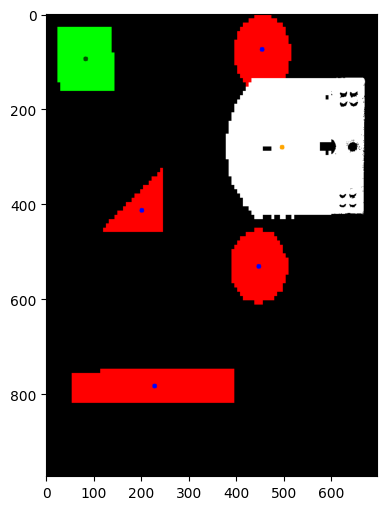

In [18]:
def visualize_centroids(grid_image: np.ndarray, grid: np.ndarray, discretized_img: np.ndarray, grid_size: int):
    """
    Visualizes the centroids on the discretized image.
    """
    # Create a copy of the discretized image for visualization
    vis_image = discretized_img.copy()
    
    # Calculate cell dimensions
    cell_height = discretized_img.shape[0] // grid_size
    cell_width = discretized_img.shape[1] // grid_size
    
    # Function to draw a circle at a given grid position
    def draw_circle(image, centroid, color):
        y, x = centroid
        # Convert grid coordinates to image coordinates
        image_y = int(y * cell_height + cell_height / 2)
        image_x = int(x * cell_width + cell_width / 2)
        cv2.circle(image, (image_x, image_y), radius=5, color=color, thickness=-1)
    
    # Identify and draw centroids
    start_positions = np.argwhere(grid == 3)
    if start_positions.size > 0:
        start_centroid = start_positions.mean(axis=0)
        draw_circle(vis_image, start_centroid, color=(0, 165, 255))  # White
    
    goal_positions = np.argwhere(grid == 2)
    if goal_positions.size > 0:
        goal_centroid = goal_positions.mean(axis=0)
        draw_circle(vis_image, goal_centroid, color=(0, 80, 0))      # Green
    
    obstacle_positions = np.argwhere(grid == 1)
    if obstacle_positions.size > 0:
        obstacle_grid = (grid == 1).astype(np.uint8)
        num_labels, labels_im = cv2.connectedComponents(obstacle_grid)
        for label in range(1, num_labels):
            positions = np.argwhere(labels_im == label)
            centroid = positions.mean(axis=0)
            draw_circle(vis_image, centroid, color=(255, 0, 0))       # Red
    
    # Display the image with centroids
    show_cv2_img(vis_image, (6,6), color="BGR")

# Call the function
visualize_centroids(grid_image, grid, discretized_img, grid_size)

Observations:
- compute_centroids should output a list
- visualize_centroids should take that list as input
- centroids is one way of doing it there are other ways, like the corners (assuming square obstacles and goal and robot + enlarging them to avoid collision)
- if using centroid, the robot should be filled (remove black holes) for better centroid computation

5. Everything together

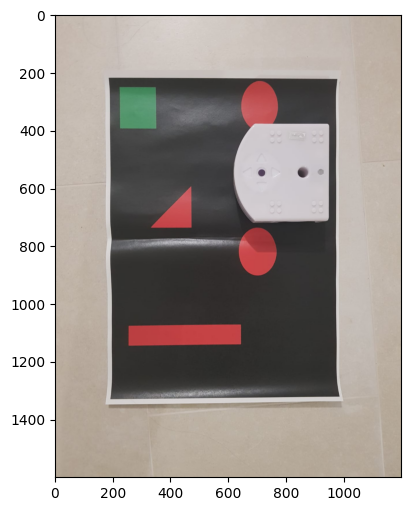

In [19]:
img_name = "r3.jpg" # a friendlier version of r2.jpg
img = get_image(os.path.join("..", "robot-env", img_name))

show_cv2_img(img, (6,6), "BGR")

Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Start (white) centroid at grid position: [29.04216315 80.9431714 ]
Goal (green) centroid at grid position: [ 9.5 13.5]
Number of obstacles found: 4
Obstacle 1 centroid at grid position: [ 7.20524017 73.18777293]
Obstacle 2 centroid at grid position: [41.88435374 32.40816327]
Obstacle 3 centroid at grid position: [54.25       71.99596774]
Obstacle 4 centroid at grid position: [80.18944844 35.2470024 ]


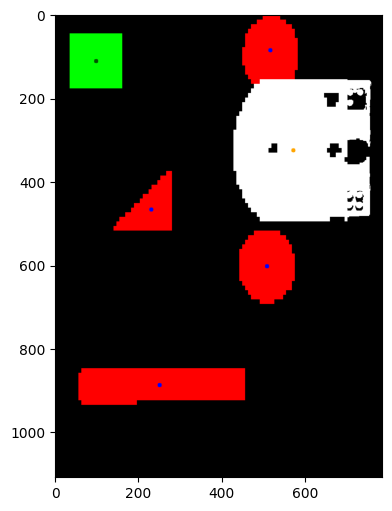

In [20]:
corners = correct_distorsion(img)
img = crop_image(img, corners)

T_W = 196
T_RH = 140 
T_RL = 120
T_GH = 138
T_GL = 140

img = threshold_image(img, T_W = T_W, T_RH = T_RH, T_RL = T_RL, T_GH = T_GH, T_GL = T_GL)
img = filter_start_goal_noise(img)

grid_size = 100
grid_image, discretized_img = discretize_image(img, grid_size)
grid = image_to_grid(grid_image)
compute_centroids(grid)
visualize_centroids(grid_image, grid, discretized_img, grid_size)

Observations:
- create a pipeline to handle the camera (get img at freq f and process it)
- output should be the grid +/or the centroids or the coordinates of the corners of the enlarged obstacles & robot (to avoid collision)
- Create a live visualization of edges (setting sigma if need) and of the color thresholding

In [21]:
import numpy as np
import cv2 as cv
img_name = "r3.jpg" # a friendlier version of r2.jpg
img = get_image(os.path.join("..", "robot-env", img_name))
corners = correct_distorsion(img)
img = crop_image(img, corners)
img_vis=img.copy() #have a copy for visualization

white_mask = cv.inRange(img, np.array([190, 190, 190]), np.array([255, 255, 255]))

kernel_close = np.ones((10, 20), np.uint8)
kernel_open = np.ones((10, 10), np.uint8)
filled_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel_close) #close inside blobs
filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, kernel_open) #remove small blobs

cnt, hierarchy = cv.findContours(filled_mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) #or SIMPLE
cnt = sorted(cnt, key=cv.contourArea, reverse=True) #sort by largest cnt, there should be only one with small blob removal but we never know :)
Thymio_mask=np.zeros_like(filled_mask,dtype=np.uint8)
cv2.drawContours(Thymio_mask, [cnt[0]], -1, 255, thickness=cv2.FILLED)

#------------------------------------------------ABOVE IS ONLY A DIFFERENT WAY TO GET MASK FOR THYMIO
#Get Centroid
M = cv2.moments(filled_mask)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
Thymio_center=(cX,cY)
Thymio_nose_coord=np.argmax(np.linalg.norm(cnt[0].reshape(-1,2)- np.array([cX, cY]),2,axis=1))


#Get orientation 
rect = cv.minAreaRect(cnt[0])
box = cv.boxPoints(rect) #get oriented box vertices
box = np.int32(box) #get integer

#Get direction
box_mask=np.zeros_like(Thymio_mask,dtype=np.uint8)
cv2.drawContours(box_mask, [box], -1, 255, thickness=cv2.FILLED)
intersection= (box_mask & ~Thymio_mask)*255
M = cv2.moments(intersection)
cX_nose = int(M["m10"] / M["m00"])
cY_nose = int(M["m01"] / M["m00"])
Thymio_angle=np.atan2(cY_nose-cY,cX_nose-cX)





#some plots
cv2.line(img_vis, Thymio_center, tuple(cnt[0][Thymio_nose_coord,:,:].reshape(2)), (255,0,255), 2)
cv2.line(img_vis, Thymio_center, (cX_nose,cY_nose), (255,0,0), 2)
print(f"The orientation is {Thymio_angle} radians thus {Thymio_angle*180/np.pi} degrees")
cv.drawContours(img_vis,[box],0,(0,0,255),2)
cv2.drawContours(img_vis, cnt[0], -1, (0,255,0), 3)
cv2.imshow("test",img_vis)
cv.waitKey(0)
cv.destroyAllWindows()

The orientation is -3.132972177477657 radians thus -179.50608310138125 degrees


# 5. A*
5.1 A* path


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop


def heuristic(a, b):
    #Euclidian Distance
    return np.linalg.norm(a-b,2)

def a_star_search(map_grid, start, goal):
    #Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set,(0+heuristic(start,goal),0,start))
    
    came_from = {}
    g_costs = {start: 0}
    explored = set()
    cost_map=-1*np.zeros_like(map_grid)

    while open_set:  # While the open set is not empty

        current_f_cost, current_g_cost, current_pos = heappop(open_set)
        # Add the current node to the explored set
        explored.add(current_pos)

        # Check if the goal has been reached
        if current_pos == goal:
             break
        # Get the neighbors of the current node 8 neighbors
        neighbors = [(current_pos[0],current_pos[1]+1),
                     (current_pos[0],current_pos[1]-1),
                     (current_pos[0]-1,current_pos[1]),
                     (current_pos[0]+1,current_pos[1]),
                     (current_pos[0]+1,current_pos[1]+1),
                     (current_pos[0]-1,current_pos[1]-1),
                     (current_pos[0]-1,current_pos[1]+1),
                     (current_pos[0]+1,current_pos[1]-1),

            ]
    
        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]) and (map_grid[neighbor]!=-1):
                
                # Calculate tentative_g_cost
                tentative_g_cost = g_costs[current_pos]+(map_grid[neighbor]) #cost is 1 y default on the map_grid

                # If this path to neighbor is better than any previous one
                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    # Update came_from and g_costs
                    came_from[neighbor] = current_pos
                    g_costs[neighbor] = tentative_g_cost
                    f_cost=tentative_g_cost+heuristic(neighbor,goal)
                    cost_map[neighbor]=f_cost
                    # Add neighbor to open set
                    heappush(open_set, (f_cost,tentative_g_cost,neighbor))
    
    # Reconstruct path
    if current_pos == goal:
        #Reconstruct the path
        path=[goal]
        while path[-1]!=start:
            path.append(came_from[path[-1]])
        print(path)
        return path[::-1], explored, cost_map  # Return reversed path, explored cells and cost_map for visualization
    else:
        return None, explored